In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots","Images"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, dir,sigm , zeroone, progress, sgd, load, save, gc, Param, KnetArray, gpu, Data, nll, training, dropout,conv4, pool, mat, nll, zeroone,
progress, sgd, param, param0, dropout, relu, Data,sigm, Adam, minibatch, cycle# param, param0, xavier
using Statistics: mean
using Base.Iterators: flatten
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)
using Statistics
using Random
import Knet.param0
import Knet.param
import Knet.xavier
using Knet, Luxor, Plots,Printf

In [2]:
Pkg.status()

    Status `~/.julia/environments/v1.1/Project.toml`
  [5ae59095] Colors v0.9.5
  [5789e2e9] FileIO v1.0.6
  [7073ff75] IJulia v1.18.0
  [6218d12a] ImageMagick v0.7.1
  [916415d5] Images v0.17.3
  [033835bb] JLD2 v0.1.2
  [682c06a0] JSON v0.20.0
  [1902f260] Knet v1.2.1
  [ae8d54c2] Luxor v1.2.0
  [23992714] MAT v0.5.0
  [91a5bcdd] Plots v0.24.0
  [438e738f] PyCall v1.91.1


In [3]:
std(gaussian(5,3; std=0.05))

0.052109734951241424

In [2]:
using Images, Colors

In [3]:
# Some utilities to make model definitions easier:
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
paramd1(d...; init=gaussian, atype=atype())=Param(atype(init(d...)))
paramd2(d...; init=gaussian, atype=atype())=Param(atype(init(d...;std=0.005)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)
param1(d...; atype=atype())=param(d...; init=ones, atype=atype)
xavier(o,i) = (s = sqrt(2/(i+o)); 2s .* rand(o,i) .- s)
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})

atype (generic function with 1 method)

In [4]:
cd()
cd("Desktop/DeepProject/21.04.19")
X=load("datax2.jld2","a");
Y=load("datay.jld2","b");
Z=load("dataz.jld2","c");
summary(X)

"224×224×3×1440 Array{Float64,4}"

In [5]:
ind=randperm(size(Y,1));
Ynew=Y[ind,1];
Xnew=X[:,:,:,ind];
Znew=Z[:,:,:,ind];
summary(Znew)

"7×7×512×1440 Array{Float32,4}"

In [13]:
1296/1440

0.9

In [6]:
Xdtrn=Xnew[:,:,:,1:1296]
Ydtrn=Ynew[1:1296];
Zdtrn=Znew[:,:,:,1:1296]
summary(Xdtrn)

"224×224×3×1296 Array{Float64,4}"

In [7]:
dtrn=minibatch(Xdtrn,Zdtrn,32;xsize=(224,224,3,32),xtype=atype(),ytype=atype())

Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}([0.27451 0.796078 … 0.407843 0.698039; 0.270588 0.796078 … 0.396078 0.694118; … ; 0.478431 0.4 … 0.192157 0.129412; 0.498039 0.372549 … 0.192157 0.12549], Float32[14.4002 0.0 … 8.30414 9.88001; 0.0 0.0 … 0.151525 10.3678; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 32, 1296, false, 1265, 1:1296, false, (224, 224, 3, 32), (7, 7, 512, 1296), KnetArray{Float32,N} where N, KnetArray{Float32,N} where N)

In [8]:
(x,y) = first(dtrn)
println.(summary.((x,y)));

224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [9]:
Xtst=Xnew[:,:,:,1297:1440];
Ytst=Ynew[1297:1440];
Ztst=Znew[:,:,:,1297:1440];

In [10]:
dtst=minibatch(Xtst,Ztst,32;xsize=(224,224,3,32),xtype=atype(),ytype=atype())

Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}([0.54902 0.886275 … 0.65098 0.666667; 0.545098 0.894118 … 0.654902 0.654902; … ; 0.521569 0.627451 … 0.470588 0.478431; 0.529412 0.635294 … 0.458824 0.470588], Float32[0.0 5.11417 … 0.0 0.226084; 0.0 4.94547 … 10.7661 15.6079; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 32, 144, false, 113, 1:144, false, (224, 224, 3, 32), (7, 7, 512, 144), KnetArray{Float32,N} where N, KnetArray{Float32,N} where N)

In [11]:
(x1,y1) = first(dtst)
println.(summary.((x1,y1)));


224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [12]:
summary(dtst)

"4-element Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}"

In [13]:
function trainresults(file,model; o...)
   # if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst))
           for x in takeevery(length(dtrn), progress(momentum(model,repeat(dtrn,100);lr=0.05, gamma=0.9))))
        print("done")
          # print(size(r,1))      
        r = reshape(collect(Float32,flatten(r)),(2,:))
               
          print("done")
       # Knet.gc() # To save gpu memory
    #else
       # isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
       # r = Knet.load(file,"results")
   # end
   # println(minimum(r,dims=2))
   return r
end

trainresults (generic function with 1 method)

In [24]:
@doc sgd

```
minimize(func, data, optimizer=Adam(); params)
sgd     (func, data; lr=0.1,  gclip, params)
momentum(func, data; lr=0.05, gamma=0.95, gclip, params)
nesterov(func, data; lr=0.05, gamma=0.95, gclip, params)
adagrad (func, data; lr=0.05, eps=1e-6, gclip, params)
rmsprop (func, data; lr=0.01, rho=0.9, eps=1e-6, gclip, params)
adadelta(func, data; lr=1.0,  rho=0.9, eps=1e-6, gclip, params)
adam    (func, data; lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, gclip, params)
```

Return an iterator which applies `func` to arguments in `data`, i.e.  `(func(args...) for args in data)`, and updates the parameters every iteration to minimize `func`.  `func` should return a scalar value.

The common keyword argument `params` can be used to list the `Param`s to be optimized.  If not specified, any `Param` that takes part in the computation of `func(args...)` will be updated.

The common keyword argument `gclip` can be used to implement per-parameter gradient clipping. For a parameter gradient `g`, if `norm(g) > gclip > 0`, `g` is scaled so that its norm is equal to `gclip`. If not specified no gradient clipping is performed.

These functions do not perform optimization, but return an iterator that can. Any function that produces values from an iterator can be used with such an object, e.g. `progress!(sgd(f,d))` iterates the sgd optimizer and displays a progress bar. For convenience, appending `!` to the name of the function iterates and returns `nothing`, i.e. `sgd!(...)` is equivalent to `(for x in sgd(...) end)`.

We define optimizers as lazy iterators to have explicit control over them:

  * To report progress use `progress(sgd(f,d))`.
  * To run until convergence use `converge(sgd(f,cycle(d)))`.
  * To run multiple epochs use `sgd(f,repeat(d,n))`.
  * To run a given number of iterations use `sgd(f,take(cycle(d),n))`.
  * To do a task every n iterations use `(task() for (i,j) in enumerate(sgd(f,d)) if i%n == 1)`.

These functions apply the same algorithm with the same configuration to every parameter by default. `minimize` takes an explicit optimizer argument, all others call `minimize` with an appropriate optimizer argument (see `@doc update!` for a list of possible optimizers). Before calling [`update!`](@ref) on a `Param`, `minimize` sets its `opt` field to a copy of this default optimizer if it is not already set. The `opt` field is used by the `update!` function to determine the type of update performed on that parameter.  If you need finer grained control, you can set the optimizer of an individual `Param` by setting its `opt` field before calling one of these functions. They will not override the `opt` field if it is already set, e.g. `sgd(model,data)` will perform an `Adam` update for a parameter whose `opt` field is an `Adam` object. This also means you can stop and start the training without losing optimization state, the first call will set the `opt` fields and the subsequent calls will not override them.

Given a parameter `w` and its gradient `g` here are the updates applied by each optimizer:

```
# sgd (http://en.wikipedia.org/wiki/Stochastic_gradient_descent)
w .= w - lr * g

# momentum (http://jlmelville.github.io/mize/nesterov.html)
v .= gamma * v - lr * g
w .= w + v

# nesterov (http://jlmelville.github.io/mize/nesterov.html)
w .= w - gamma * v
v .= gamma * v - lr * g
w .= w + (1 + gamma) * v

# adagrad (http://www.jmlr.org/papers/v12/duchi11a.html)
G .= G + g .^ 2
w .= w - lr * g ./ sqrt(G + eps)

# rmsprop (http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
G .= rho * G + (1-rho) * g .^ 2 
w .= w - lr * g ./ sqrt(G + eps)

# adadelta (http://arxiv.org/abs/1212.5701)
G .= rho * G + (1-rho) * g .^ 2
update = sqrt(delta + eps) .* g ./ sqrt(G + eps)
w = w - lr * update
delta = rho * delta + (1-rho) * update .^ 2

# adam (http://arxiv.org/abs/1412.6980)
v = beta1 * v + (1 - beta1) * g
G = beta2 * G + (1 - beta2) * g .^ 2
vhat = v ./ (1 - beta1 ^ t)
Ghat = G ./ (1 - beta2 ^ t)
w = w - (lr / (sqrt(Ghat) + eps)) * vhat
```


In [14]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mean(abs2.(c(x).-y))
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [15]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [16]:
# Define a convolutional layer:
struct Conv0; w; b; f; p; end
(c::Conv0)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv0(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv0(paramd1(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv0

In [17]:
# Define a convolutional layer:
struct Conv1; w; b; f; p; end
(c::Conv1)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv1(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv1(paramd1(w1,w2,cx,cy), param1(1,1,cy,1), f, pdrop)

Conv1

In [18]:

struct Conv2; w; b; f; p; end
(c::Conv2)(x) = c.f.(conv4(c.w, dropout(x,c.p);padding=0))
Conv2(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv2(paramd1(w1,w2,cx,cy), param1(1,1,cy,1), f, pdrop)

Conv2

In [19]:
struct Conv3; w; b; f; p; end
(c::Conv3)(x) = c.f.(conv4(c.w, dropout(x,c.p);padding=1))
Conv3(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv3(paramd1(w1,w2,cx,cy), param1(1,1,cy,1), f, pdrop)

Conv3

In [20]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(paramd1(o,i), param0(o), f, pdrop)

Dense

In [21]:
# Redefine dense layer (See mlp.ipynb):
struct Dense0; w; b; f; p; end
(d::Dense0)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense0(i::Int,o::Int,f=relu;pdrop=0.5) = Dense0(paramd2(o,i), param1(o), f, pdrop)

Dense0

In [22]:
# Redefine dense layer (See mlp.ipynb):
struct Dense1; w; b; f; p; end
(d::Dense1)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense1(i::Int,o::Int,f=relu;pdrop=0.5) = Dense1(paramd1(o,i), param0(o), f, pdrop)

Dense1

In [23]:
lenet1 =   Chain(Conv0(3,3,3,64),
                 Conv1(3,3,64,128),
                 Conv1(3,3,128,256),
                Conv1(3,3,256,256),
                Conv1(3,3,256,512),
                Conv3(2,2,512,512))
summary.(l.w for l in lenet1.layers)

6-element Array{String,1}:
 "3×3×3×64 Param{KnetArray{Float32,4}}"   
 "3×3×64×128 Param{KnetArray{Float32,4}}" 
 "3×3×128×256 Param{KnetArray{Float32,4}}"
 "3×3×256×256 Param{KnetArray{Float32,4}}"
 "3×3×256×512 Param{KnetArray{Float32,4}}"
 "2×2×512×512 Param{KnetArray{Float32,4}}"

In [24]:
cnn2 = trainresults("cnn2.jld2", lenet1);

2.77e+02  100.00%┣████████████████████▉┫ 4000/4000 [07:39/07:39, 8.71i/s]
done

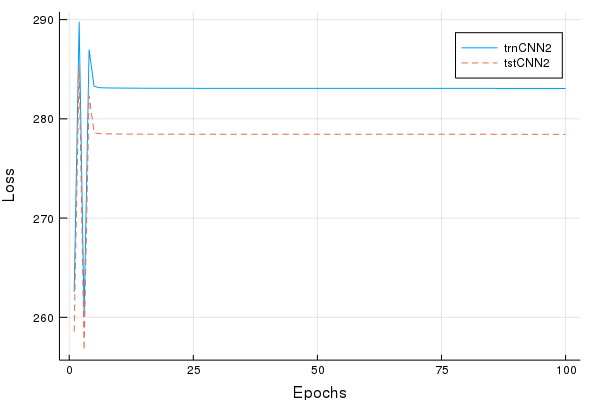

In [25]:
plot([cnn2[1,:], cnn2[2,:]],
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Loss")

In [26]:
cd()
cd("Desktop/DeepProject")
Knet.save("lenet1last2.jld2","b",lenet1)

In [ ]:
lenet1

In [38]:
lenet1.layers
(x1) = first(lenet1.layers)
println(summary((x1)));
x1.w

Conv0


P(KnetArray{Float32,4}(3,3,3,64))

In [43]:
# Define a convolutional layer:
struct Conv0; w; b; f; p; end
(c::Conv0)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv0(w1,w2,cy::Int,f=relu;pdrop=0) = Conv0(x1.w, x1.b, f, pdrop)
Conv0(w1,w2) = Conv0(x1.w, x1.b, f, pdrop)

hesap(a,b)
hesap(a,b)



Conv0

In [42]:
convert(Array{Float32,4},lenet1.layers[1].w)

3×3×3×64 Array{Float32,4}:
[:, :, 1, 1] =
 -0.00871214  -0.000751225  -0.000579689
 -0.0248748    0.0152113    -0.00329432 
 -0.00121078  -0.00879293   -0.00723424 

[:, :, 2, 1] =
  0.00767459  -0.00325299  -0.00778595
  0.00223166   0.00391672  -0.0215079 
 -0.0116552   -0.0188883    0.0121926 

[:, :, 3, 1] =
 -0.00284774  -0.00394341  -0.0372736 
 -0.0188273   -0.00772812  -0.013955  
 -0.001945     0.00459553   0.00382264

[:, :, 1, 2] =
 -0.0297519   -0.0202923   -0.00962888
 -0.0276394   -0.0295004    0.00112609
 -0.00656154  -0.00332122  -0.019275  

[:, :, 2, 2] =
 -0.0027709    -0.0100992  -0.0235549 
  0.00241004   -0.0131165  -0.00225613
  0.000284919  -0.0163133  -0.0123686 

[:, :, 3, 2] =
 -0.0230993   0.000930059  -0.0082123
 -0.0128929  -0.0180306    -0.0150899
  0.0115776  -0.00879394   -0.0121415

[:, :, 1, 3] =
 -0.682393  -0.70804   -0.714568
 -0.708471  -0.724795  -0.699235
 -0.715787  -0.703025  -0.693483

[:, :, 2, 3] =
 -0.621252  -0.646083  -0.633705
 -0.62367

In [47]:
j=paramd1(5,5)

P(KnetArray{Float32,2}(5,5))

In [46]:
x1.w[2,1,1,1]

-0.0062158154f0

In [26]:
cd()
cd(readdir, "Desktop/DeepProject")

10-element Array{String,1}:
 "21.04.19"          
 "CNNModel.ipynb"    
 "Dataset.ipynb"     
 "Deep (1).ipynb"    
 "DeepCNNMOdel.ipynb"
 "datax.jld2"        
 "datay.jld2"        
 "dtrn.jld2"         
 "dtst.jld2"         
 "lenet1.jld2"       

In [184]:
cd()
cd("Desktop/DeepProject")
save("lenet1.jld2","b",lenet1)

In [27]:
cd("Desktop/DeepProject")
CC=Knet.load("lenet1.jld2","b")

┌ Warning: type Main.Chain does not exist in workspace; reconstructing
└ @ JLD2 /home/mvgl/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Main.Conv0 does not exist in workspace; reconstructing
└ @ JLD2 /home/mvgl/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Main.Conv1 does not exist in workspace; reconstructing
└ @ JLD2 /home/mvgl/.julia/packages/JLD2/KjBIK/src/data.jl:1153
┌ Warning: type Main.Conv3 does not exist in workspace; reconstructing
└ @ JLD2 /home/mvgl/.julia/packages/JLD2/KjBIK/src/data.jl:1153


getfield(JLD2.ReconstructedTypes, Symbol("##Main.Chain#371"))((getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv0#372"))(P(KnetArray{Float32,4}(3,3,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), Knet.relu, 0), getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv1#373"))(P(KnetArray{Float32,4}(3,3,64,128)), P(KnetArray{Float32,4}(1,1,128,1)), Knet.relu, 0), getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv1#373"))(P(KnetArray{Float32,4}(3,3,128,256)), P(KnetArray{Float32,4}(1,1,256,1)), Knet.relu, 0), getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv1#373"))(P(KnetArray{Float32,4}(3,3,256,256)), P(KnetArray{Float32,4}(1,1,256,1)), Knet.relu, 0), getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv1#373"))(P(KnetArray{Float32,4}(3,3,256,512)), P(KnetArray{Float32,4}(1,1,512,1)), Knet.relu, 0), getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv3#374"))(P(KnetArray{Float32,4}(2,2,512,512)), P(KnetArray{Float32,4}(1,1,512,1)), Knet.relu, 0)))

In [29]:
CC.layers
(x1) = first(CC.layers)
println(summary((x1)));
x1.w

getfield(JLD2.ReconstructedTypes, Symbol("##Main.Conv0#372"))


P(KnetArray{Float32,4}(3,3,3,64))

In [53]:
lenet2 =   Chain(Conv0(3,3,3,64,relu),
                    Dense0(788544,6))
summary.(l.w for l in lenet2.layers)

2-element Array{String,1}:
 "3×3×3×64 Param{KnetArray{Float32,4}}"
 "6×788544 Param{KnetArray{Float32,2}}"

In [35]:
cnn2 = trainresults("cnn2.jld2", lenet1);

2.02e+02  100.00%┣████████████████████▉┫ 4000/4000 [07:33/07:33, 8.82i/s]
done

In [135]:
cnn2[3,:]

MethodError: MethodError: no method matching getindex(::Base.Generator{Base.Generator{Base.Iterators.Filter{getfield(Main, Symbol("##172#176")){Int64},Base.Iterators.Enumerate{Knet.Progress{Knet.Minimize{Knet.Repeat}}}},getfield(Main, Symbol("##171#175"))},getfield(Main, Symbol("##173#177")){Chain}}, ::Int64, ::Colon)

In [153]:
 cnn2 = reshape(collect(Float32,flatten(cnn2)),(4,:))

2.95e+02  0.03%┣                       ┫ 1/4000 [00:03/03:18:24, 2.98s/i]

MethodError: SYSTEM: show(lasterr) caused an error

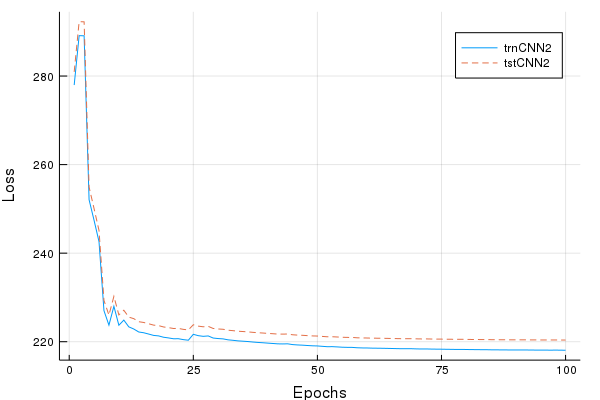

In [37]:
plot([cnn2[1,:], cnn2[2,:]],
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Loss")

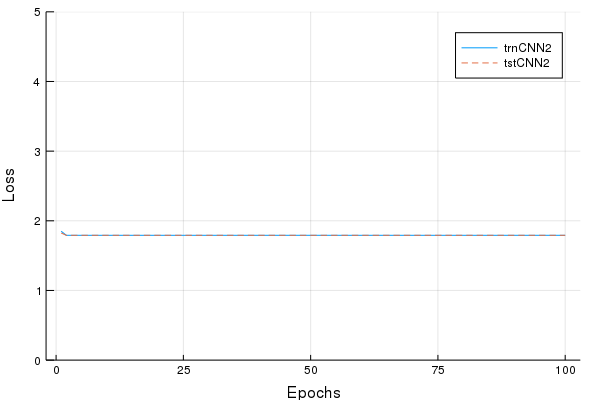

In [25]:
plot([cnn2[1,:], cnn2[2,:]], ylim=(0.0,5),
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Loss")

In [58]:
cnn1 = trainresults("cnn2.jld2", lenet2);

Train from scratch? stdin> y
1.55e+00  100.00%┣█████████████████████┫ 4500/4500 [09:00/09:00, 8.34i/s]
Float32[1.80996; 1.82021; 0.833333; 0.820313]


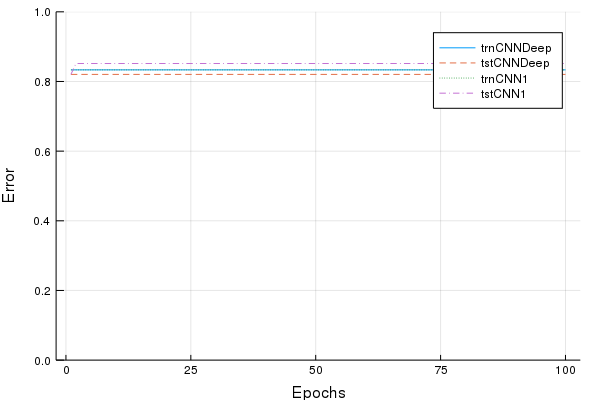

In [62]:
plot([cnn2[3,:], cnn2[4,:],cnn1[3,:], cnn1[4,:]], ylim=(0.0,1),
     labels=[:trnCNNDeep :tstCNNDeep :trnCNN1 :tstCNN1],xlabel="Epochs",ylabel="Error")

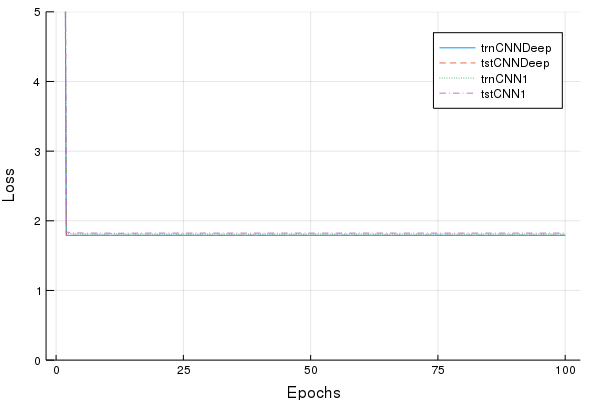

In [63]:
plot([cnn2[1,:], cnn2[2,:],cnn1[1,:], cnn1[2,:]], ylim=(0.0,5),
     labels=[:trnCNNDeep :tstCNNDeep :trnCNN1 :tstCNN1],xlabel="Epochs",ylabel="Loss")

In [ ]:
@